In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix,classification_report
import itertools
import os
from pathlib import Path
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

%matplotlib inline

2024-07-14 19:25:24.031109: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
CPUs = tf.config.list_physical_devices('CPU')
print("Num CPUs Available: ", len(CPUs))

# Iterate over the list of CPUs and print their details
for cpu in CPUs:
    print("Name:", cpu.name, "Type:", cpu.device_type)

Num CPUs Available:  1
Name: /physical_device:CPU:0 Type: CPU


In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot


--2024-07-14 19:25:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.24’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.003s  

2024-07-14 19:25:32 (3.86 MB/s) - ‘helper_functions.py.24’ saved [10246/10246]



In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [5]:
#dataset = 'C:/Users/LENOVO/Documents/TA Leo'
dataset = '/mnt/c/Users/LENOVO/Documents/TA Leo'
walk_through_dir(dataset)

There are 2 directories and 0 images in '/mnt/c/Users/LENOVO/Documents/TA Leo'.
There are 0 directories and 1503 images in '/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH BENER'.
There are 0 directories and 428 images in '/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH GRADE B'.


In [6]:
images_dir = Path(dataset)
filepaths = list(images_dir.glob(r'**/*.JPG')) + list(images_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df

,Filepath,Label
0,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH BEN...,GABAH BENER
1,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH BEN...,GABAH BENER
2,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH BEN...,GABAH BENER
3,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH BEN...,GABAH BENER
4,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH BEN...,GABAH BENER
...,...,...
1926,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH GRA...,GABAH GRADE B
1927,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH GRA...,GABAH GRADE B
1928,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH GRA...,GABAH GRADE B
1929,/mnt/c/Users/LENOVO/Documents/TA Leo/GABAH GRA...,GABAH GRADE B


In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [8]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1236 validated image filenames belonging to 2 classes.
Found 308 validated image filenames belonging to 2 classes.
Found 387 validated image filenames belonging to 2 classes.


In [10]:
from tensorflow.keras.layers import Rescaling
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224), #dimensions
  layers.experimental.preprocessing.Rescaling(1./255),
])


data_augmentation = tf.keras.Sequential([
 
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

In [11]:
# Load the pretained model
pretrained_model = tf.keras.applications.vgg19.VGG19(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [12]:
checkpoint_path = "Checkpoint_model"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)
stop = EarlyStopping(monitor="val_loss", #val-loss
                                                  patience=5,restore_best_weights=True)

In [13]:
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

# Define the function to create a TensorBoard callback ######
def create_tensorboard_callback(training_logs, experiment_name):
    log_dir = os.path.join('training_logs', 'classification', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir)
    return tensorboard_callback

In [14]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.40)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.40)(x)

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        stop,
        create_tensorboard_callback("training_logs", "classification"),
        checkpoint_callback,
    ]
)

Epoch 1/50


2024-07-14 19:25:48.360467: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-07-14 19:25:48.698631: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-07-14 19:25:50.494211: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.
2024-07-14 19:25:50.839207: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


 1/39 [..............................] - ETA: 7:37 - loss: 4.4898 - accuracy: 0.5625

2024-07-14 19:25:56.584813: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


39/39 [==============================] - 337s 9s/step - loss: 4.1132 - accuracy: 0.6610 - val_loss: 1.9215 - val_accuracy: 0.7955
Epoch 2/50
39/39 [==============================] - 294s 8s/step - loss: 3.1312 - accuracy: 0.7152 - val_loss: 1.0879 - val_accuracy: 0.8182
Epoch 3/50
39/39 [==============================] - 286s 7s/step - loss: 2.3632 - accuracy: 0.7646 - val_loss: 0.6498 - val_accuracy: 0.8669
Epoch 4/50
39/39 [==============================] - 286s 7s/step - loss: 1.9142 - accuracy: 0.7832 - val_loss: 0.4407 - val_accuracy: 0.9221
Epoch 5/50
39/39 [==============================] - 289s 7s/step - loss: 1.5078 - accuracy: 0.8139 - val_loss: 0.2881 - val_accuracy: 0.9448
Epoch 6/50
39/39 [==============================] - 286s 7s/step - loss: 1.1398 - accuracy: 0.8463 - val_loss: 0.2676 - val_accuracy: 0.9513
Epoch 7/50
39/39 [==============================] - 285s 7s/step - loss: 1.1085 - accuracy: 0.8422 - val_loss: 0.2464 - val_accuracy: 0.9545
Epoch 8/50
39/39 [======

In [15]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.4f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


    Test Loss: 0.0232
Test Accuracy: 98.97%


In [16]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = list(test_df.Label)
print(classification_report(y_test, pred))

13/13 [==============================] - 80s 6s/step
               precision    recall  f1-score   support

  GABAH BENER       0.99      1.00      0.99       293
GABAH GRADE B       1.00      0.96      0.98        94

     accuracy                           0.99       387
    macro avg       0.99      0.98      0.99       387
 weighted avg       0.99      0.99      0.99       387



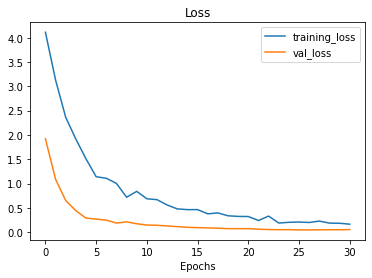

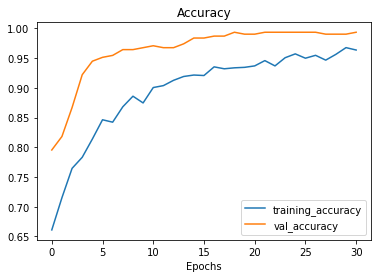

In [17]:
plot_loss_curves(history)


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


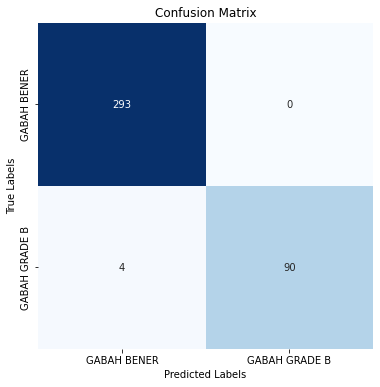

In [22]:
conf_matrix = confusion_matrix(y_test, pred)
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=labels.values(), yticklabels=labels.values())
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


